# Ellipse calculations

## Imports

In [1]:
# Python standard library
import sys
import csv
import os

# Scientific computing

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.ndimage
import sklearn.mixture
import pandas as pd
from scipy.spatial import ConvexHull
from skimage import measure
#plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', 'repo')
sys.path.append(PORE_STATS_BASE_DIRECTORY)


import optical_imaging as oi
import oi_file
import image_processing

In [2]:
import os
os.getcwd()

'C:\\Users\\codyt\\Documents\\cell_code\\updated_code\\pore_stats\\notebooks\\oi'

In [3]:
print(PORE_STATS_BASE_DIRECTORY)

C:\Users\codyt\Documents\cell_code\updated_code\pore_stats\repo\oi


## Constants

In [4]:
save_data = True
save_plot = True

nm = 10**(-9.)
um = 10**(-6.)

## Load video and events

In [43]:
# Define file path
#data_base_path = oi_file.data_base_path
data_base_path = 'D:/'
date = '10-8-20'
particle_type = '/hl60d'
channel_type = '/25_50_25x150'
file_index = '1'



file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/test_camera_0.raw'

#file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index+ '/bin/frames/frames.txt'


# Set output file path
oi_events_filepath= data_base_path + date + particle_type + channel_type + '/oi/' + file_index + '/events/test_camera_0' + '_events.json'

# Open video
res_x = 880
res_y = 140
fps = 11104
exp = 1
camera = 0

## camera = 0 is raw 16bpp chronos
oi_vid = oi_file.Video(file_path, res_x, res_y, fps, exp,camera=camera)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_filepath)

print 'loaded', len(oi_events), 'oi events'

loaded 280 oi events


## Output

In [44]:
#ellipse_path = oi_file.ellipse_base_path
ellipse_path = 'D:/analysis/'
save_base_path = ellipse_path + date + '/' + particle_type + '/' + channel_type + '/' + file_index

print save_base_path

D:/analysis/10-8-20//hl60d//25_50_25x150/1


# Create stage

D:/10-8-20/hl60d/25_50_25x150/oi/1/stage/stage_0.txt
[[180, 125], [180, 20], [730, 20], [730, 125]]
[-0.  1.]


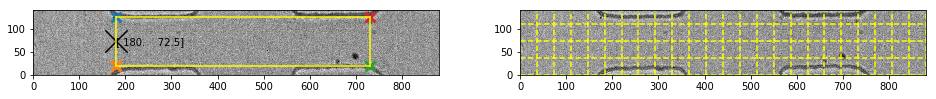

In [45]:
reload(oi)
template_index = 102
template_frame = oi_vid.get_frame(template_index,camera=camera)
 
stage_file_path = data_base_path + date + particle_type + channel_type + '/oi/'+ file_index + '/stage/stage_0.txt' 
print stage_file_path
cs = oi.load_stage_file(stage_file_path)
print cs
c0 = cs[0]
c1 = cs[1]
c2 = cs[2]
c3 = cs[3]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
#oi_stage._length_microns = 150
oi_stage.plot_stage()

## Load ellipses

In [46]:
#oi_ellipse_base_path = oi_file.ellipse_base_path
oi_ellipse_path = ellipse_path  + date + '/' + particle_type + '/' + channel_type + '/' + file_index + '/ellipses.txt'

ellipsess = []


with open(oi_ellipse_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            ellipsess.append([])
            continue
            
        else:
            ellipse = []
            for ele in row:
                try:
                    ellipse.append(float(ele))
                except:
                    ellipse.append(0)
                    
            ellipsess[-1].append(ellipse)

In [47]:
oi_contour_path = ellipse_path  + date + '/' + particle_type + '/' + channel_type + '/' + file_index + '/contours.txt'

contourss = []


with open(oi_contour_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        next(file_reader)
        
        
    for row in file_reader:
        
        if row[0] == 'event #':
            # New event
            contourss.append([])
            continue
            
        else:
            contour = []
            for ele in row:
                try:
                    contour.append(float(ele))
                except:
                    contour.append(eval(ele))
                    
            contourss[-1].append(contour)

## Filter

In [48]:
# Load keep indices
filter_file_path = ellipse_path + date + '/' + particle_type + '/' + channel_type + '/' + file_index + '/filter'
with open(filter_file_path, 'r') as filter_file_handle:
    filter_file_reader = csv.reader(filter_file_handle, delimiter = '\t')
    for row in filter_file_reader:
        if row[0] == 'events':
            keep_indices = [int(ele) for ele in row[1:]]
            




# Manual filter
#manual_filter_file_path = filter_file_path.replace('filter', 'manual_filter.txt')
#manual_remove_indices = []
#with open(manual_filter_file_path, 'r') as manual_filter_file_handle:
    #reader = csv.reader(manual_filter_file_handle)
    #for row in reader:
        #manual_remove_indices.append(int(row[0]))
        
#keep_indices = [keep_index for keep_index in keep_indices if keep_index not in manual_remove_indices]
    
    
print 'loaded keep indices (', len(keep_indices), 'events total):\n', keep_indices
filtered_oi_events = [oi_events[i] for i in range(len(oi_events)) if i in keep_indices]
filtered_ellipsess = [ellipsess[i] for i in range(len(ellipsess)) if i in keep_indices]
filtered_contourss = [contourss[i] for i in range(len(contourss)) if i in keep_indices]

oi_events = filtered_oi_events
ellipsess = filtered_ellipsess
contourss = filtered_contourss

loaded keep indices ( 157 events total):
[0, 1, 2, 3, 4, 10, 14, 16, 17, 18, 19, 20, 22, 24, 28, 29, 30, 33, 34, 37, 38, 39, 41, 42, 44, 45, 51, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 84, 86, 89, 91, 92, 94, 95, 96, 98, 99, 103, 104, 105, 106, 111, 117, 118, 119, 120, 121, 123, 125, 126, 127, 129, 130, 133, 134, 135, 138, 140, 143, 148, 149, 151, 152, 153, 154, 158, 159, 160, 164, 166, 168, 169, 171, 175, 176, 177, 178, 179, 181, 184, 185, 187, 192, 193, 194, 195, 198, 200, 201, 203, 205, 207, 209, 210, 213, 214, 216, 218, 219, 222, 223, 224, 225, 229, 230, 231, 232, 234, 236, 237, 238, 240, 241, 243, 245, 247, 248, 252, 255, 256, 257, 260, 261, 262, 264, 265, 266, 269, 271, 272, 273, 274, 275, 276, 277, 278]


## Calculations

In [49]:
features = ['event_num', 'ellipse_num', 'tf', 'x_pix', 'xc_pix', 'xc_um', 'y_pix', 'yc_pix', 'yc_um', 'a_pix', 'a_um', 'b_pix', 'b_um', 'r_pix', 'r_um', 'aspect-ratio', 'theta_rad', 'speed_pix/frame', 'speed_m/s']
output_file_path = save_base_path + '/calculations1'

with open(output_file_path, 'w') as output_file_handle:
    output_writer = csv.writer(output_file_handle, delimiter = ',')

    output_writer.writerow(features)

    
    for i, oi_event in enumerate(oi_events):

        event_num = i

        ellipses = ellipsess[i]
        for j, ellipse in enumerate(ellipses):
            ellipse_num = j

            detection_num = int(ellipse[0])

            tf = oi_events[event_num]._detections[detection_num]._tf

            x_pix = ellipse[1]
            y_pix = ellipse[2]
            xc_pix, yc_pix = oi_stage.get_channel_coordinates(x_pix, y_pix)
            xc_um = oi_stage.pixels_to_meters(xc_pix,camera=camera)
            yc_um = oi_stage.pixels_to_meters(yc_pix,camera=camera)

            a_pix = ellipse[3]
            b_pix = ellipse[4]
            a_um = oi_stage.pixels_to_meters(a_pix,camera=camera)
            b_um = oi_stage.pixels_to_meters(b_pix,camera=camera)
            r_pix = np.sqrt(a_pix*b_pix)
            r_um = np.sqrt(a_um*b_um)

            aspect_ratio = a_pix/b_pix

            theta_rad = ellipse[5]


            speed_pixperframe = 0
            speed_mpers = 0
            if (j != 0) and (j != (len(ellipsess[i]) - 1)):
                ellipse_prev = ellipses[j-1]
                ellipse_next = ellipses[j+1]

                x_prev_pix = ellipse_prev[1]
                y_prev_pix = ellipse_prev[2]

                x_next_pix = ellipse_next[1]
                y_next_pix = ellipse_next[2]

                detection_num_prev = int(ellipse_prev[0])
                detection_num_next = int(ellipse_next[0])

                tf_prev = oi_events[event_num]._detections[detection_num_prev]._tf
                tf_next = oi_events[event_num]._detections[detection_num_next]._tf

                speed_pixperframe = (((x_next_pix - x_pix)**2. + (y_next_pix - y_pix)**2.)**.5 + \
                ((x_prev_pix - x_pix)**2. + (y_prev_pix - y_pix)**2.)**.5)/2.

                speed_mpers = oi_stage.pixels_to_meters(speed_pixperframe,camera=camera)
                speed_mpers = speed_mpers * fps


            features = [event_num, ellipse_num, tf, x_pix, xc_pix, xc_um, y_pix, yc_pix, yc_um, a_pix, a_um,\
                        b_pix, b_um, r_pix, r_um, aspect_ratio, theta_rad, speed_pixperframe, speed_mpers]


            output_writer.writerow(features)


0.942075361902


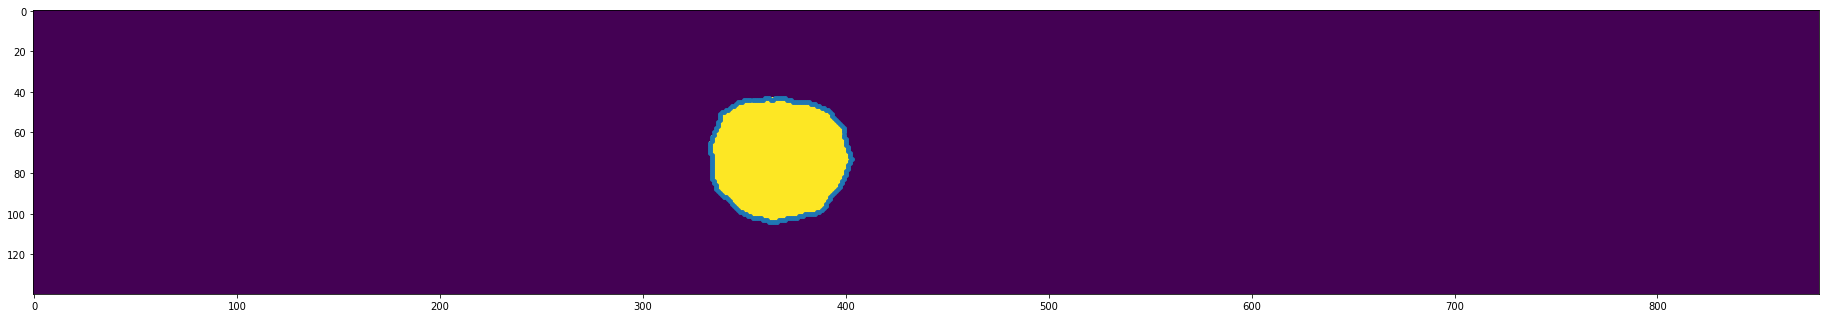

In [12]:
x_pix = contourss[20][13][2]
y_pix = contourss[20][13][3]
point = np.asarray(zip(x_pix,y_pix))

mask_img = np.zeros((140,880))
mask = cv2.fillPoly(mask_img, pts =[point], color=(1))
per = measure.perimeter(mask)
ar = np.sum(mask)
plt.figure(figsize=(32,16))
plt.imshow(mask)
plt.scatter(x_pix,y_pix,s=15)

print(2*np.sqrt(np.pi*ar)/(per))

271.76450198781714

In [ ]:
point = zip(x_pix,y_pix)
ConvexHull(np.asarray([list(a) for a in xy_cont ]))

In [51]:
features = ['event_num', 'contour_num', 'tf', 'x_pix', 'xc_pix', 'xc_um', 'y_pix', 'yc_pix', 'yc_um', 'r_pix', 'r_um', 
            'I_std','perimeter','area','circularity','deformation']
output_file_path = save_base_path + '/calculations_contour1'

with open(output_file_path, 'w') as output_file_handle:
    output_writer = csv.writer(output_file_handle, delimiter = ',')

    output_writer.writerow(features)

    
    for i, oi_event in enumerate(oi_events):

        event_num = i

        contours = contourss[i]
        for j, contour in enumerate(contours):
            contour_num = j

            detection_num = int(contour[0])

            tf = oi_events[event_num]._detections[detection_num]._tf
            
            x_pix = contour[1][0]
            y_pix = contour[1][1]
            x_cont = contour[2]
            y_cont = contour[3]
            xy_cont = zip(x_cont,y_cont)
            
            xc_pix, yc_pix = oi_stage.get_channel_coordinates(x_pix, y_pix)
            
            xc_um = oi_stage.pixels_to_meters(xc_pix,camera=camera)
            yc_um = oi_stage.pixels_to_meters(yc_pix,camera=camera)
            
            xdist = (np.asarray(x_cont)-x_pix)**2
            ydist = (np.asarray(y_cont)-y_pix)**2
            
            r_pix = np.sqrt(xdist+ydist).mean()
            r_um = oi_stage.pixels_to_meters(r_pix,camera=camera)
            frame = oi_vid.get_frame(tf)
            
            points= np.asarray(zip(x_cont,y_cont))
            mask_img = np.zeros((res_y,res_x))
            mask = cv2.fillPoly(mask_img, pts =[points], color=(1))
            
            perimeter = measure.perimeter(mask)
            area = np.sum(mask)
            
            x_closed = np.where(mask==1)[1]
            y_closed = np.where(mask==1)[0]
            img = oi_vid.get_frame(tf)
            norm_img = image_processing.normalize(img[y_closed,x_closed])
            
            I_std = np.std(norm_img)
            
            
            
            #hull = ConvexHull(np.asarray([list(a) for a in xy_cont ]))
            
            #perimeter = hull.area
            
            #area = hull.volume
            
            circularity = 2*np.sqrt(np.pi)*np.sqrt(area)/perimeter
            
            deformation = 1 - circularity


            features = [event_num, detection_num, tf, x_pix, xc_pix, xc_um, y_pix, yc_pix, yc_um,
                        r_pix, r_um,I_std,perimeter,area,circularity,deformation ]


            output_writer.writerow(features)


In [327]:
event = 50
frame = 20

x = contourss[event][frame][2]
y= contourss[event][frame][3]

xcm = contourss[event][frame][1][0]
ycm = contourss[event][frame][1][1]

xd = (np.asarray(x)-xcm)**2
yd = (np.asarray(y)-ycm)**2

np.sqrt(xd+yd).mean()

30.802600407425597

In [311]:
import cv2

In [491]:
event = 100
frame = 20
det_num = int(contourss[event][frame][0])
x = contourss[event][frame][2]
y= contourss[event][frame][3]

points= np.asarray(zip(x,y))


mask_img = np.zeros((140,880))
mask = cv2.fillPoly(mask_img, pts =[points], color=(1))
x_closed = np.where(mask==1)[1]
y_closed = np.where(mask==1)[0]
img = oi_vid.get_frame(oi_events[event]._detections[det_num]._tf)
norm_img = image_processing.normalize(img[y_closed,x_closed])
np.std(norm_img)

0.21160681620027166

In [457]:
x_closed

array([594, 595, 596, ..., 605, 606, 607], dtype=int64)

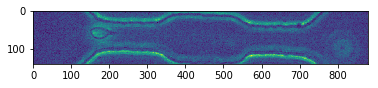

In [443]:
plt.imshow(oi_vid.get_frame(oi_events[event]._detections[det_num]._tf))

In [499]:
1.*np.array(100)*(100./383.)

26.109660574412537

In [500]:
1.*100

100.0